# Regression Analysis
By Atwine Mugume Twinamatsiko

In this notebook, I am going to go through different models of regression while doing a thorough run through the methods as much as I can.

This notebook is intended for study purposed, I have compiled it with the heart of helping someone out there who may have just begun their journey in AI and ML to get started easily.

I will be using the Scikit Learn documentation to get the implementation of the methods  in the various regression models.

[Here is the link](https://scikit-learn.org/stable/)

I will also be getting data from Yahoo finance [here](https://finance.yahoo.com/quote/AAPL/history?p=AAPL)

The models I am going to look at are:

- Linear Regression
- Ridge Regression
- Support Vector Machines
- Stochastic Gradient Descent Regression



In [1]:
#import the necessary modules that we are going to use for this notebook

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import re


In [2]:
#let's read in the data and take a look at what it looks like
df = pd.read_csv('AAPL.csv', parse_dates=['Date'])

In [3]:
#lets have a look at the top rows in the dataset
df.head(5)

,Date,Open,High,Low,Close,Adj Close,Volume
0,2016-09-06,107.900002,108.300003,107.510002,107.699997,102.663673,26880400
1,2016-09-07,107.830002,108.760002,107.070000,108.360001,103.292809,42364300
2,2016-09-08,107.250000,107.269997,105.239998,105.519997,100.585609,53002000
3,2016-09-09,104.639999,105.720001,103.129997,103.129997,98.307373,46557000
4,2016-09-12,102.650002,105.720001,102.529999,105.440002,100.509361,45292800


In [4]:
#what are the dimensions of the data
df.shape

(754, 7)

In [5]:
#In this particular instance we are going to be predicting the Adj close price
#This is the final price after  company actions
#Let's extract the features and the label now
label = df['Adj Close']

In [6]:
features = df.drop(columns='Adj Close')

In [7]:
features.head()

,Date,Open,High,Low,Close,Volume
0,2016-09-06,107.900002,108.300003,107.510002,107.699997,26880400
1,2016-09-07,107.830002,108.760002,107.070000,108.360001,42364300
2,2016-09-08,107.250000,107.269997,105.239998,105.519997,53002000
3,2016-09-09,104.639999,105.720001,103.129997,103.129997,46557000
4,2016-09-12,102.650002,105.720001,102.529999,105.440002,45292800


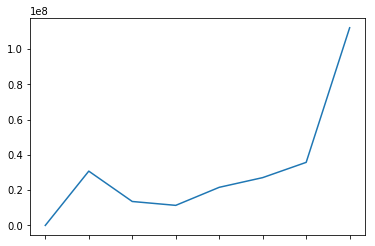

In [8]:
#lets look at the features descriptive stats
features.describe()['Volume'].plot()

In [9]:
#pre processing the date
#The date normally has so many variables.
#I am going to borrow a method from fastai that will break this date down for us


def add_datepart(df, fldname, drop=True, time=False):
    """add_datepart converts a column of df from a datetime64 to many columns containing
    the information from the date. This applies changes inplace.

    Parameters:
    -----------
    df: A pandas data frame. df gain several new columns.
    fldname: A string that is the name of the date column you wish to expand.
        If it is not a datetime64 series, it will be converted to one with pd.to_datetime.
    drop: If true then the original date column will be removed.
    time: If true time features: Hour, Minute, Second will be added.

    Examples:
    ---------

    >>> df = pd.DataFrame({ 'A' : pd.to_datetime(['3/11/2000', '3/12/2000', '3/13/2000'], infer_datetime_format=False) })
    >>> df

        A
    0   2000-03-11
    1   2000-03-12
    2   2000-03-13

    >>> add_datepart(df, 'A')
    >>> df

        AYear AMonth AWeek ADay ADayofweek ADayofyear AIs_month_end AIs_month_start AIs_quarter_end AIs_quarter_start AIs_year_end AIs_year_start AElapsed
    0   2000  3      10    11   5          71         False         False           False           False             False        False          952732800
    1   2000  3      10    12   6          72         False         False           False           False             False        False          952819200
    2   2000  3      11    13   0          73         False         False           False           False             False        False          952905600
    """
    fld = df[fldname]
    fld_dtype = fld.dtype
    if isinstance(fld_dtype, pd.core.dtypes.dtypes.DatetimeTZDtype):
        fld_dtype = np.datetime64

    if not np.issubdtype(fld_dtype, np.datetime64):
        df[fldname] = fld = pd.to_datetime(fld, infer_datetime_format=True)
    targ_pre = re.sub('[Dd]ate$', '', fldname)
    attr = ['Year', 'Month', 'Week', 'Day', 'Dayofweek', 'Dayofyear',
            'Is_month_end', 'Is_month_start', 'Is_quarter_end', 'Is_quarter_start', 'Is_year_end', 'Is_year_start']
    if time: attr = attr + ['Hour', 'Minute', 'Second']
    for n in attr: df[targ_pre + n] = getattr(fld.dt, n.lower())
    df[targ_pre + 'Elapsed'] = fld.astype(np.int64) // 10 ** 9
    if drop: df.drop(fldname, axis=1, inplace=True)

In [10]:
add_datepart(features,'Date')

In [11]:
#there are more features now added to the dataset
features.shape

(754, 18)

In [12]:
#let's see how this looks like now
features.head()

,Open,High,Low,Close,Volume,Year,Month,Week,Day,Dayofweek,Dayofyear,Is_month_end,Is_month_start,Is_quarter_end,Is_quarter_start,Is_year_end,Is_year_start,Elapsed
0,107.900002,108.300003,107.510002,107.699997,26880400,2016,9,36,6,1,250,False,False,False,False,False,False,1473120000
1,107.830002,108.760002,107.070000,108.360001,42364300,2016,9,36,7,2,251,False,False,False,False,False,False,1473206400
2,107.250000,107.269997,105.239998,105.519997,53002000,2016,9,36,8,3,252,False,False,False,False,False,False,1473292800
3,104.639999,105.720001,103.129997,103.129997,46557000,2016,9,36,9,4,253,False,False,False,False,False,False,1473379200
4,102.650002,105.720001,102.529999,105.440002,45292800,2016,9,37,12,0,256,False,False,False,False,False,False,1473638400


In [13]:
#its a good idea to keep the file that has been worked on in case you make some changes
features.to_csv('Features.csv')

## Modeling

Now that we have some data that we cna work with we are ready to beging modeling.

To begin we shall start with our base model of Linear regression

For each model we shall use:
- KFold Cross validation for model selection
- Grid search to help in parameter tuning.

## Evaluation metrics

For evaluation we will use:
- Mean Square Error
- Root Mean Square Error

### Linear Regression

In [14]:
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import KFold,cross_val_score,cross_validate
from sklearn.model_selection import train_test_split

In [15]:
#first we are going to split the data so that we will be able to  use it in the algorithms
x_train, x_test, y_train, y_test = train_test_split(features,label,test_size=0.25, random_state=40)

In [16]:
print('These are the new shapes of the data')
x_train.shape,y_train.shape, x_test.shape,y_test.shape

These are the new shapes of the data


((565, 18), (565,), (189, 18), (189,))

In [17]:
#define cross validation
kf = KFold(n_splits=10,shuffle=False,random_state=40)

In [18]:
#we need to work on the metrics
from sklearn.metrics import mean_squared_error

#to get the root mean square error we have to modify the sklearn code on mean sqr error 
def root_mean_square_error(n,m):
    return np.sqrt(mean_squared_error(n,m))

## Linear Regression Model

In [19]:
#base model
lrg_model = LinearRegression()

lrg_model.get_params

<bound method BaseEstimator.get_params of LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)>

In [20]:
#let's build the model based on the default parameters
lrg_model.fit(x_train,y_train)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

In [21]:
#let's do a prediction on the x_test data
pred = lrg_model.predict(x_test)

In [22]:
#evaluation of this model
mean_squared_error(y_test,pred)

0.09374686928639407

In [23]:
root_mean_square_error(y_test,pred)

0.30618110537130483

### Evaluation Function

Since we are going to do many evaluations, we won't have to keep writing the evaluation codes. We are going to write a code that takes us through the steps and gives us the results.

For reuseability its a great idea to write functions so that we save on the time we work with.

In [24]:
def print_eval(predictions):
    
    print('The MSE of the model is {:3f}'.format(mean_squared_error(y_test,predictions)))
    print('\n')
    print('The RMSE of the model is {:3f}'.format(root_mean_square_error(y_test,predictions)))

In [25]:
#test the function
print_eval(pred)

The MSE of the model is 0.093747


The RMSE of the model is 0.306181


In [26]:
#let's use KFold cross validation to see the error
cv = cross_validate(lrg_model,features,label,verbose=1,scoring='neg_mean_squared_error',cv=kf)

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.1s finished


In [27]:
#the cross validate method above returns a dictionary
#from the result below we get a worse mean score than expected
np.mean(pd.DataFrame(cv)['test_score'])

-137.0181129633599

In [28]:
#this ow we retrieve a dictionary of the error functions that can be used when working with 
#sklearn
from  sklearn.metrics import SCORERS
SCORERS.keys()

dict_keys(['explained_variance', 'r2', 'max_error', 'neg_median_absolute_error', 'neg_mean_absolute_error', 'neg_mean_squared_error', 'neg_mean_squared_log_error', 'accuracy', 'roc_auc', 'balanced_accuracy', 'average_precision', 'neg_log_loss', 'brier_score_loss', 'adjusted_rand_score', 'homogeneity_score', 'completeness_score', 'v_measure_score', 'mutual_info_score', 'adjusted_mutual_info_score', 'normalized_mutual_info_score', 'fowlkes_mallows_score', 'precision', 'precision_macro', 'precision_micro', 'precision_samples', 'precision_weighted', 'recall', 'recall_macro', 'recall_micro', 'recall_samples', 'recall_weighted', 'f1', 'f1_macro', 'f1_micro', 'f1_samples', 'f1_weighted', 'jaccard', 'jaccard_macro', 'jaccard_micro', 'jaccard_samples', 'jaccard_weighted'])

### Using Grid Search

We normally use grid search to help tune better the model, through checking each parameter to find which one is the best of the set we have.

In [29]:
#lets check the parameters of the lenear regression model
lrg_model.get_params

<bound method BaseEstimator.get_params of LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)>

In [30]:
#in this case we have one variable to check, normalize = True
lrg_model_2 = LinearRegression(normalize=True)

In [31]:
lrg_model_2.fit(x_train,y_train)
pred_2 = lrg_model_2.predict(x_test)

In [32]:
print_eval(pred_2)

The MSE of the model is 0.093741


The RMSE of the model is 0.306172


It can be observed that this model may be disadvantageous because its very simple, in my view, there is a limited number of parameters to tune in order to reduce the error. 

The coefficient estimates for Ordinary Least Squares rely on the independence of the features. When features are correlated and the columns of the design matrix  have an approximate linear dependence, the design matrix becomes close to singular and as a result, the least-squares estimate becomes highly sensitive to random errors in the observed target, producing a large variance. This situation of multicollinearity can arise, for example, when data are collected without an experimental design.

# Ridge Regression

In [33]:
#import ridge regression
from sklearn.linear_model import Ridge

#import ridge regression
rg_model  = Ridge()

In [34]:
#let's see the parameters we can take advantage of 
rg_model.get_params

<bound method BaseEstimator.get_params of Ridge(alpha=1.0, copy_X=True, fit_intercept=True, max_iter=None,
      normalize=False, random_state=None, solver='auto', tol=0.001)>

In [35]:
#base model
rg_model.fit(x_train,y_train)
rg_pred = rg_model.predict(x_test)
print_eval(rg_pred)

The MSE of the model is 0.135296


The RMSE of the model is 0.367826


/anaconda3/lib/python3.6/site-packages/scipy/linalg/basic.py:40: RuntimeWarning: scipy.linalg.solve
Ill-conditioned matrix detected. Result is not guaranteed to be accurate.
Reciprocal condition number/precision: 2.2170778866777962e-18 / 1.1102230246251565e-16
  RuntimeWarning)


In [36]:
#i don't want to see warning
import warnings
warnings.filterwarnings('ignore')

In [37]:
#ridge regression  adds a parameer alpha which penelizes the way the weights affect the model
#let's see how the alpha value changes graphically
n_alphas = 200
alphas = np.logspace(-10, -2, n_alphas)

coefs = []
for a in alphas:
    ridge = Ridge(alpha=a, fit_intercept=False)
    ridge.fit(x_train, y_train)
    coefs.append(ridge.coef_)

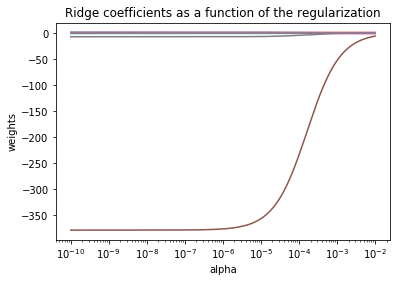

In [38]:
# Display results

ax = plt.gca()

ax.plot(alphas, coefs)
ax.set_xscale('log')
ax.set_xlim(ax.get_xlim()[::])  # reverse axis
plt.xlabel('alpha')
plt.ylabel('weights')
plt.title('Ridge coefficients as a function of the regularization')
plt.axis('tight')
plt.show()

From the image above we can see how this works, as alpha slowly increases the weights of the algorithm are penalized towards zero, which is something that is to be solved with the normal linear regression model.

Let us run the vearsion with cross validation to see if we can get a better score than what we got in the linear model

In [39]:
from sklearn.linear_model import RidgeCV

rgcv = RidgeCV()

In [40]:
#let's see the parameters in this ridge model with cross validation
rgcv.get_params

<bound method BaseEstimator.get_params of RidgeCV(alphas=array([ 0.1,  1. , 10. ]), cv=None, fit_intercept=True,
        gcv_mode=None, normalize=False, scoring=None, store_cv_values=False)>

In [41]:
#we have an addition for cross validation to help us tune, this was not in the other model
#let's  set the cross val param
#please note also that there is an array of values to check for alpha
rgcv = RidgeCV(cv = kf)

In [42]:
rgcv.fit(x_train,y_train)
rg_pred = rgcv.predict(x_test)
print_eval(rg_pred)

The MSE of the model is 0.136310


The RMSE of the model is 0.369202


There is not much change in the score function, for this particular model we can implement grid search and run a number of values to make it better

In [43]:
from sklearn.model_selection import GridSearchCV

grid = {
    'alpha':np.logspace(-10, -2, n_alphas),

}

model = GridSearchCV(
    rg_model,
    param_grid=grid,
    cv=50,
    error_score='neg_mean_squared_error'
)

model.fit(x_train, y_train)

GridSearchCV(cv=50, error_score='neg_mean_squared_error',
             estimator=Ridge(alpha=1.0, copy_X=True, fit_intercept=True,
                             max_iter=None, normalize=False, random_state=None,
                             solver='auto', tol=0.001),
             iid='warn', n_jobs=None,
             param_grid={'alpha': array([1.00000000e-10, 1.09698580e-10, 1.20337784e-10, 1.32008840e-10,
       1.44811823e-10, 1.58856513e-10, 1.74263339e-10, 1.9116440...
       1.72258597e-03, 1.88965234e-03, 2.07292178e-03, 2.27396575e-03,
       2.49450814e-03, 2.73644000e-03, 3.00183581e-03, 3.29297126e-03,
       3.61234270e-03, 3.96268864e-03, 4.34701316e-03, 4.76861170e-03,
       5.23109931e-03, 5.73844165e-03, 6.29498899e-03, 6.90551352e-03,
       7.57525026e-03, 8.30994195e-03, 9.11588830e-03, 1.00000000e-02])},
             pre_dispatch='2*n_jobs', refit=True, return_train_score=False,
             scoring=None, verbose=0)

In [44]:
model.best_params_ #for this data we should use this alpha

{'alpha': 0.01}

In [45]:
rg3_model  = Ridge(alpha=0.01)
rg3_model.fit(x_train,y_train)
prd = rg3_model.predict(x_test)
print_eval(prd)

The MSE of the model is 0.129912


The RMSE of the model is 0.360434


From the MSE above we have become better, however for this problem, the simple linear regression seems to be having the headway.

Let's try another model.

## Kernel Ridge Regression

In [46]:
from sklearn.kernel_ridge import KernelRidge

krg = KernelRidge()

krg.get_params

<bound method BaseEstimator.get_params of KernelRidge(alpha=1, coef0=1, degree=3, gamma=None, kernel='linear',
            kernel_params=None)>

In [47]:
#this model has the implementation of a kernel
#this is a hyper plane modeled from the original plane that helps to classify the results
#base model
krg.fit(x_train,y_train)
prdk = krg.predict(x_test)
print_eval(prdk)

The MSE of the model is 22.097880


The RMSE of the model is 4.700838


In [48]:
#let's grid search the parameters
grid = {
    'alpha':np.logspace(-10, -2, n_alphas),
}

model = GridSearchCV(
    krg,
    param_grid=grid,
    cv=10,
    #error_score='neg_mean_squared_error'
)

model.fit(x_train, y_train)

GridSearchCV(cv=10, error_score='raise-deprecating',
             estimator=KernelRidge(alpha=1, coef0=1, degree=3, gamma=None,
                                   kernel='linear', kernel_params=None),
             iid='warn', n_jobs=None,
             param_grid={'alpha': array([1.00000000e-10, 1.09698580e-10, 1.20337784e-10, 1.32008840e-10,
       1.44811823e-10, 1.58856513e-10, 1.74263339e-10, 1.91164408e-10,
       2.09704640e-10, 2.30043012e-10, 2.523...
       1.72258597e-03, 1.88965234e-03, 2.07292178e-03, 2.27396575e-03,
       2.49450814e-03, 2.73644000e-03, 3.00183581e-03, 3.29297126e-03,
       3.61234270e-03, 3.96268864e-03, 4.34701316e-03, 4.76861170e-03,
       5.23109931e-03, 5.73844165e-03, 6.29498899e-03, 6.90551352e-03,
       7.57525026e-03, 8.30994195e-03, 9.11588830e-03, 1.00000000e-02])},
             pre_dispatch='2*n_jobs', refit=True, return_train_score=False,
             scoring=None, verbose=0)

In [49]:
model.best_params_ 

{'alpha': 1e-10}

In [50]:
#input the best parameter
krg = KernelRidge(alpha=1e-10)

krg.fit(x_train,y_train)
prdk = krg.predict(x_test)
print_eval(prdk)

The MSE of the model is 22.097880


The RMSE of the model is 4.700838


This method doesn't seem to be working well wit out data, because the error is way beyond what we anticipate, we move to the next model

## Support Vectore Machines

In [51]:
from sklearn.svm import SVR

sv = SVR()

In [52]:
sv.get_params

<bound method BaseEstimator.get_params of SVR(C=1.0, cache_size=200, coef0=0.0, degree=3, epsilon=0.1,
    gamma='auto_deprecated', kernel='rbf', max_iter=-1, shrinking=True,
    tol=0.001, verbose=False)>

In [53]:
#base model
sv.fit(x_train,y_train)
svp =sv.predict(x_test)
print_eval(svp)

The MSE of the model is 899.343952


The RMSE of the model is 29.989064


In [55]:
#since this is way above what we want for Measn Square Error
#we need to tune the model to make it better.
#the major tuner here is the value of C
from sklearn.model_selection import RandomSearchCV

parameters = {
    'kernel' : ['linear', 'rbf', 'poly'],
    #'gamma' :[0.1, 1, 10, 100],
    #'C':[0.1, 1, 10, 100, 1000],
    #'degree' : [0, 1, 2, 3, 4, 5, 6]
}

#let's change the scorer to mean square error
#https://medium.com/all-things-ai/in-depth-parameter-tuning-for-svc-758215394769
from sklearn.metrics import make_scorer
scorer = make_scorer(mean_squared_error, greater_is_better=False)



In [56]:
svr_gs = RandomSearchCV(sv, parameters, cv = kf, scoring=scorer)

In [ ]:
svr_gs.fit(x_train,y_train)

In [ ]:
#let's list the best parameters
svr_gs.best_params_ 

Please look at this [Link on this considering domain knowledge](https://github.com/VincentTatan/PythonAnalytics/blob/master/Youtube/Lesson%203%20%20Basic%20Python%20for%20Data%20Analytics%20(Stocks%20Prediction.ipynb)